## Aplicação de Modelagem de Tópicos
### Projeto para disciplina de Métodos Numéricos
#### Rafael Figueredo Guimarães 

Um **Modelo de Tópico** pode ser definido como uma técnica que visa descobrir tópicos em vários documentos de texto. Esses tópicos são abstratos por natureza, de modo que, palavras relacionadas entre si formam um tópico.

Nesse aplicação será o usado o conjunto de dados **“20 Newsgroup”** do sklearn. disponivel no link abaixo
https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import umap
from numba import *
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings('ignore')
%matplotlib inline


In [75]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

O conjunto de dados possui 11.314 documentos de que serão distribuídos em 20 grupos de notícias distintas

In [83]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

**Pré-processamento de Dados**

Vamos seguir os seguintes passos:

    1. Tokenization divisão do texto em frases, e frases em palavras, palavras com letras minusculas e romoção da pontuação. 
    2. Palavras com menos de três caracteres serão removidos.
    3. Todas as palavras irrelevantes seão removidas
    4. Palavras em terceira pessoa são alteradas para primeira pessoa, e os verbos no passado e futuro são alterados para o presente.
    5. Palavras flexionadas são reduzidas ao formato raíz

In [77]:
news_df = pd.DataFrame({'document':documents})

# remover tudo que não é palavra, exemplo (,.!?)
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removendo palavras pequenas
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# faz todas as palavras com letra minuscula (lowercase)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [78]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) 

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
    
news_df['clean_doc'] = detokenized_doc

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape # verifica o formato do documento


(11314, 1000)

**Usaremos o TruncatedSVD do sklearn, o próximo passo é representar cada termo e documento como um vetor. Será usada a matriz de termo do documento e a decomporemos em várias matrizes.**

In [89]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

**Agora vamos separar as palavras em 20 Tópicos**

In [81]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print(" ")

Topic 0: 
like
know
people
think
good
time
thanks
 
Topic 1: 
thanks
windows
card
drive
mail
file
advance
 
Topic 2: 
game
team
year
games
season
players
good
 
Topic 3: 
drive
scsi
disk
hard
card
drives
problem
 
Topic 4: 
windows
file
window
files
program
using
problem
 
Topic 5: 
government
chip
mail
space
information
encryption
data
 
Topic 6: 
like
bike
know
chip
sounds
looks
look
 
Topic 7: 
card
sale
video
offer
monitor
price
jesus
 
Topic 8: 
know
card
chip
video
government
people
clipper
 
Topic 9: 
good
know
time
bike
jesus
problem
work
 
Topic 10: 
think
chip
good
thanks
clipper
need
encryption
 
Topic 11: 
thanks
right
problem
good
bike
time
window
 
Topic 12: 
good
people
windows
know
file
sale
files
 
Topic 13: 
space
think
know
nasa
problem
year
israel
 
Topic 14: 
space
good
card
people
time
nasa
thanks
 
Topic 15: 
people
problem
window
time
game
want
bike
 
Topic 16: 
time
bike
right
windows
file
need
really
 
Topic 17: 
time
problem
file
think
israel
long
mail
 
Topi

## Visualização dos Tópicos

No gráfico abaixo cada ponto um documento, e as cores representam os grupos de noticias

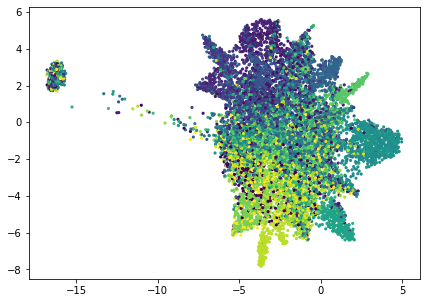

In [82]:
X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = dataset.target,
s = 10, # size
edgecolor='none')